In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

## Pascal VOC

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar')]

In [4]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

In [8]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [9]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/VOC2007/Annotations'),
 PosixPath('data/pascal/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOC2007/SegmentationClass')]

In [10]:
JPEGS = 'VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]
len(list(IMG_PATH.iterdir()))

[PosixPath('data/pascal/VOC2007/JPEGImages/008512.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/005968.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/009780.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/003524.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008095.jpg')]

5011

In [12]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [13]:
len(trn_j[IMAGES])
len(trn_j[ANNOTATIONS])

2501

7844

In [14]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

In [15]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1]) 
        # trn_j[ANNO] x,y,w,h to trn_anno y1,x1,y2,x2 (lower left, upper right), not upper left lower right
        # since y axis is drawn backward (0 on top) due to opencv?
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [16]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [17]:
trn_j[ANNOTATIONS][0][BBOX]

[155, 96, 196, 174]

In [18]:
im0_a = trn_anno[im0_d[ID]][0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [19]:
cats[7]

'car'

In [20]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])
# y1,x1,y2,x2 to x1,y1,w,h for plotting


In [21]:
??open_image

In [22]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [23]:
str(IMG_PATH)

'data/pascal/VOC2007/JPEGImages'

In [24]:
im.shape

(333, 500, 3)

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [26]:
def draw_outline(o, lw):
    # draw a box with black outline around the object?
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))

    draw_outline(patch, 4)

In [28]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

img shape: (333, 500, 3)


array([ 96, 155, 269, 350])

array([155,  96, 195, 173])

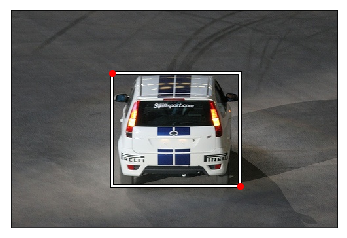

In [29]:
ax = show_img(im)
b = bb_hw(im0_a[0])
print(f'img shape: {im.shape}')
im0_a[0] # y1 x1 y2 x2
b # x1,y1,w,h
draw_rect(ax, b)
plt.plot([im0_a[0][1], im0_a[0][3]],[im0_a[0][0], im0_a[0][2]],'ro')


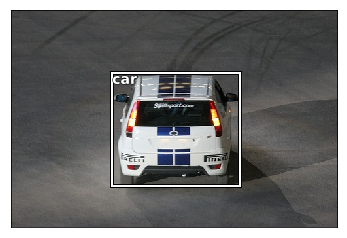

In [30]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])


In [31]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [32]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [33]:
trn_anno[17]
cats[15]
cats[13]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

'person'

'horse'

(364, 480, 3)


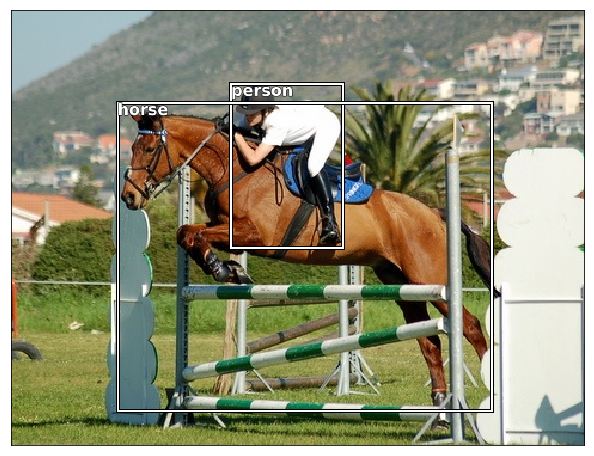

In [34]:
draw_idx(17)

## Largest item classifier

In [35]:
# get largest bbox for each pic
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    # sort by area of bbox
    return b[0]

In [36]:
for a,b in trn_anno.items():
    print(a)
    print(b)
#     print(b[0][-2:])
#     print(b[0][2:])
    print(b[0][0][-2:])
    print(b[0][0][:2])
    break

12
[(array([ 96, 155, 269, 350]), 7)]
[269 350]
[ 96 155]


In [37]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [38]:
temp=17
trn_anno[temp]
trn_lrg_anno[temp]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

(array([ 77,  89, 335, 402]), 13)

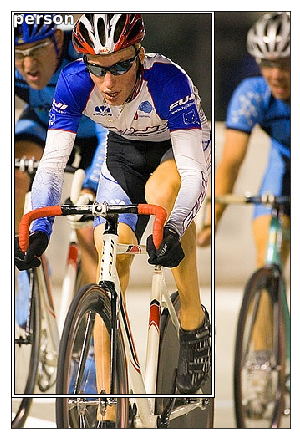

In [39]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [40]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [41]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [42]:
df.head()

,fn,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [43]:
f_model = resnet34
sz=224
bs=64

In [44]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
# No crop for object detection to prevent losing information.
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms) # random .2 of dataset will be in validation set

In [45]:
JPEGS
CSV

'VOC2007/JPEGImages'

PosixPath('data/pascal/tmp/lrg.csv')

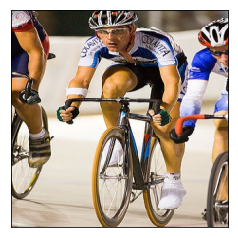

In [46]:
x,y=next(iter(md.val_dl))
# put data back to cpu in form of numpy and denormalization
show_img(md.val_ds.denorm(to_np(x))[0]);

In [47]:
x.shape
y.shape

torch.Size([64, 3, 224, 224])

torch.Size([64])

In [48]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [83]:
lrf=learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:06<00:01,  4.08it/s, loss=13.2]


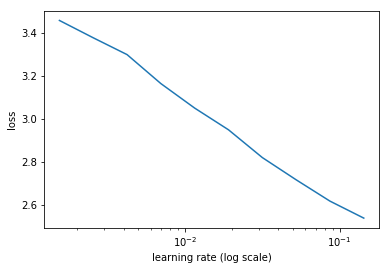

In [84]:
learn.sched.plot()
# this is weird, there should be a drop somewhere...

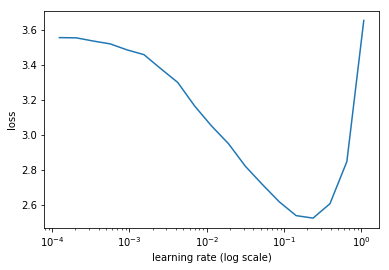

In [85]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [92]:
lr = 2e-2

In [93]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.271723   0.632128   0.804537  



[0.6321281, 0.804537259042263]

In [56]:
# learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.178562   0.770394   0.808894  
    1      0.910369   0.702508   0.827374                  
    2      0.753451   0.635635   0.826923                  



[0.6356355, 0.8269230797886848]

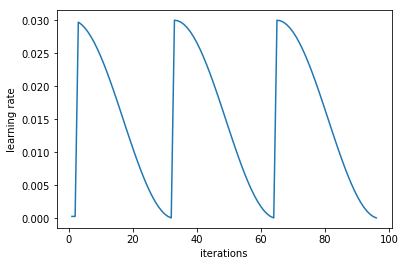

In [57]:
# learn.sched.plot_lr()

In [94]:
lrs = np.array([lr/1000,lr/100,lr])

### List of layer groups in Resnet34

In [53]:
learn.get_layer_groups()[0]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   

In [54]:
learn.get_layer_groups()[1]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_

In [55]:
learn.get_layer_groups()[2]

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=20, bias=True)
  (7): LogSoftmax()
)

In [56]:
len(learn.get_layer_groups())

3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:09<00:01,  2.96it/s, loss=4.14] 


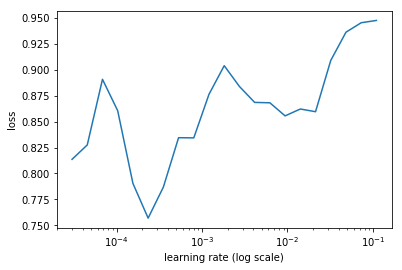

In [89]:
# freeze

learn.freeze_to(-2) # left group 1 and 2 unfreeze to finetune these
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [61]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.531474   0.640862   0.820012  



[0.640862, 0.8200120180845261]

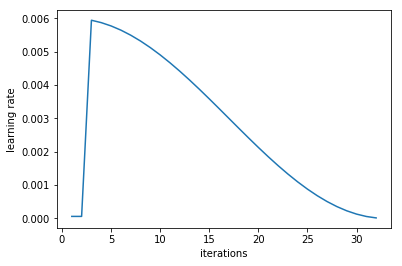

In [62]:
learn.sched.plot_lr()

In [63]:
learn.unfreeze()

In [64]:
learn.fit(lrs/5, 2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.470216   0.640472   0.818209  
    1      0.324593   0.62081    0.817608                  
    2      0.28078    0.665782   0.816707                  
    3      0.205586   0.66222    0.817758                  



[0.6622202, 0.8177584111690521]

## Bbox only: Predicting bbox coordinate (x1,y1) and (x2,y2)

In [57]:
BB_CSV = PATH/'tmp/bb.csv'

In [58]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [128]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,77 89 335 402
2,000023.jpg,1 2 461 242
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374


In [59]:
f_model=resnet34
sz=224
bs=64

Add data aug

In [ ]:
augs=[RandomFlip(tfm_y=TfmType.COORD),
     RandomRotate(30,tfm_y=TfmType.COORD),
     RandomLighting(.1,.1,tfm_y = TfmType.COORD)]
# TODO: write a blog about data augmentation in fast.ai and study the source code
# Maybe a documentation?

In [60]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs,tfm_y=TfmType.COORD)
# Note that we only have bbox coord (as y) transformation set as TfmType.COORD
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True) 
#continuous=True: predict continuous value

In [101]:
x,y=next(iter(md.val_dl))

In [102]:
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

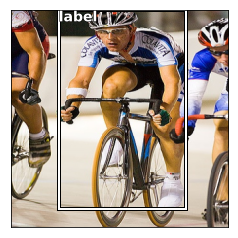

In [103]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

 ## Create custom head for BBox regression
 
 Note that if you do this, need to define your loss function (crit) with learn.crit
 
 For custom head, MaxPooling + Flatten will be removed from 2nd-to-last layer group
 ```
 AdaptiveConcatPool2d(
   (ap): AdaptiveAvgPool2d(output_size=(1, 1))
   (mp): AdaptiveMaxPool2d(output_size=(1, 1))
 ), Flatten(
 )
 ```

In [61]:

head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
# 4 ouputs for 4 coordinates to predict
# Custom head
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
# Note that if you use custom head, 
learn.opt_fn = optim.Adam

learn.crit = nn.L1Loss() # absolute value of error instead of error square
# Because squaring the error might seem a bit too much? (signify the error to much)

In [62]:
head_reg4

Sequential(
  (0): Flatten(
  )
  (1): Linear(in_features=25088, out_features=4, bias=True)
)

In [106]:
learn.lr_find(1e-5,100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:05<00:01,  4.38it/s, loss=406] 


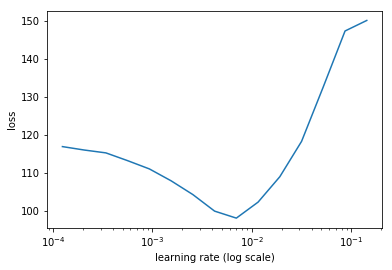

In [107]:
learn.sched.plot(5) 

In [111]:
lr = 2e-3

In [109]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      49.102805  34.117294 
    1      36.57388   28.111465                           
    2      30.64207   27.015079                           



[27.01508]

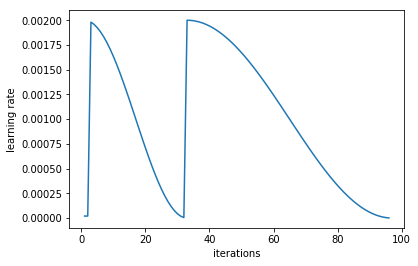

In [110]:
learn.sched.plot_lr()

In [112]:
lrs = np.array([lr/100,lr/10,lr])

In [66]:
len(learn.get_layer_groups())
learn.get_layer_groups()[1]
learn.get_layer_groups()[2]

3

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_

Sequential(
  (0): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=25088, out_features=4, bias=True)
  )
)

In [113]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      65.982509  8.371496850292736e+16



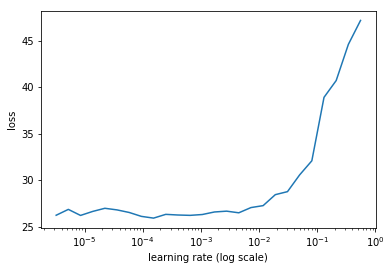

In [114]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [88]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.403215  23.83313  
    1      21.897578  21.565552                           
    2      18.31017   20.633915                           



[20.633915]

In [89]:
learn.freeze_to(-3) # equivalent to learn.unfreeze()

In [91]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      16.91954   21.1341   
    1      14.293791  20.391666                           



[20.391666]

In [92]:
learn.save('reg4')

In [93]:
learn.load('reg4')

In [94]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [95]:
y

array([[ 11.26805,  26.98402, 204.00586, 190.7586 ],
       [ 79.82516,  35.69487, 196.41469, 202.21791],
       [ 38.25734,  36.97259, 214.18236, 203.79044],
       ...,
       [131.83241,  65.46964, 162.9043 , 134.48732],
       [ 52.35977,  51.58151, 193.07887, 156.59155],
       [ 17.31162,  34.2025 , 219.96794, 204.12808]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


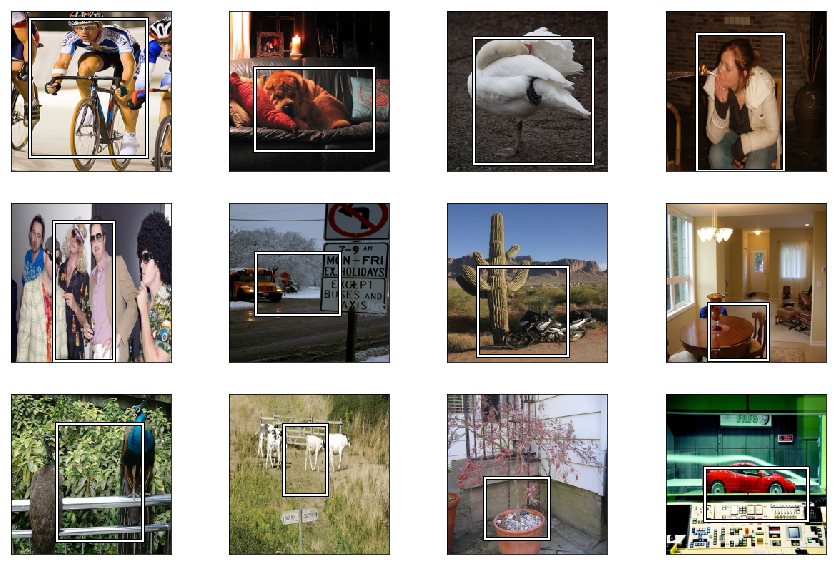

In [96]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(y[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)

## Single object detection: Predict category label and bbox coordinates within model

In [131]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [116]:
BB_CSV

PosixPath('data/pascal/tmp/bb.csv')

In [132]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, num_workers=4, val_idxs=val_idxs)
# md: data loader with bbox coordinate as y

In [100]:
md.trn_y

array([[ 96., 155., 269., 350.],
       [ 77.,  89., 335., 402.],
       [  1.,   2., 461., 242.],
       ...,
       [198.,  91., 228., 131.],
       [ 89.,  24., 311., 426.],
       [141., 191., 186., 329.]], dtype=float32)

In [107]:
CSV

PosixPath('data/pascal/tmp/lrg.csv')

In [133]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz)) 
# md2: dataset with img label as y (label coming from larger bbox)

In [134]:
md2.trn_y

array([ 6, 12, 14, ..., 16, 14,  6])

In [135]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

In [136]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [116]:
trn_ds2[0][1]

(array([ 65.,  70., 179., 156.], dtype=float32), 6)

In [137]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [135]:
# before concat
md2.trn_ds[0][1]

6

In [136]:
# after concat
md.trn_ds[0][1]

(array([ 65.,  70., 179., 156.], dtype=float32), 6)

In [125]:
x,y=next(iter(md.val_dl))

In [133]:
x.shape

torch.Size([64, 3, 224, 224])

<b>y is a tuple with y[0] are bbox coord, y[1] are labels

In [142]:
y[0][:5]


   0   49  205  180
  63    1  222  223
  23   30  205  204
  38   52  222  158
  17  102  222  178
[torch.cuda.FloatTensor of size 5x4 (GPU 0)]

In [141]:
y[1][:5]


 14
 17
  2
 14
 14
[torch.cuda.LongTensor of size 5 (GPU 0)]

In [126]:
ima=md.val_ds.ds.denorm(to_np(x))[1]
b = bb_hw(to_np(y[0][1])); b

array([  1.,  63., 222., 159.], dtype=float32)

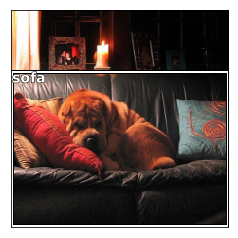

In [151]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][1]])

In [152]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [138]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    # No need for a batchnorm here since last resnetblock already have it?
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)), # predict 4 bbox coords + 20 cats at the same time
    # Note that there is no softmax or sigmoid activation applied to the last layer
)

# because we are building a custom dataset, cannot create model with ConvLearner.pretrained
# as it requires data.c (# of labels), data.is_multi, data.is_reg
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4) 
#data.c=0, data.is_multi=0
# data.is_reg=0 -> not a regression model!


learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

<b>Note that inside ConvLearner.pretrained func, a ConvnetBuilder is created and passed to ConvLearner constructor</b>

class ConvnetBuilder(): <br>
    """Class representing a convolutional network.

    Arguments:
        f: a model creation function (e.g. resnet34, vgg16, etc)
        c (int): size of the last layer
        is_multi (bool): is multilabel classification?
            (def here http://scikit-learn.org/stable/modules/multiclass.html)
        is_reg (bool): is a regression?
        ps (float or array of float): dropout parameters
        xtra_fc (list of ints): list of hidden layers with # hidden neurons
        xtra_cut (int): # layers earlier than default to cut the model, default is 0
        custom_head
    """

### Custom loss for new concat dataset

In [139]:

def detn_loss(input, target):
    # calculate loss separately for label (cross entropy) and bbox (l1_loss)
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224 # Sigmoid then scale back bbox to 224. Another example of this is from recommendation system
    # why sigmoid? Sigmoid is a nonlinear function, can capture nonlinear behavior
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20 
    # Note that F.Cross_entropy combines LogSoftmax and NLL
    # L1_loss is not on the same scale as cross_entropy, so multiply by 20


# custom metrics
def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

# set custom crit and loss
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:05<00:00,  5.09it/s, loss=586] 


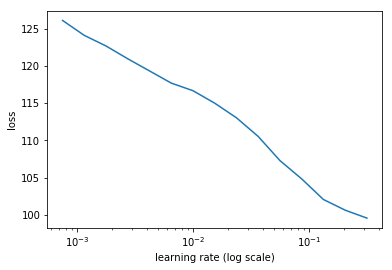

In [140]:
learn.lr_find()
learn.sched.plot()

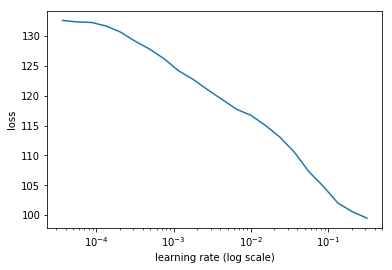

In [141]:
learn.sched.plot(3)

In [1]:
lr=1e-2

In [2]:
lr/32

0.0003125

In [143]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5)) 
# use_clr is (clr_div,cut_div). Design to use with 1 cycle
# The first one, div, is by how much your learning rate is divided to get the minimum value 
#(the maximum value is the lr you put as a parameter). 
# The second argument seems to be the way you split your cycle between increasing and decreasing: 1/5 of growth and 4/5 of descent.
# TODO: research on the SGDR in fast.ai with any simple dataset

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      73.258154  43.759407  0.802133   31.2253   
    1      51.627892  36.303246  0.833684   25.640335     
    2      41.501183  35.169754  0.832181   24.743002     



[35.169754, 0.832181490957737, 24.74300217628479]

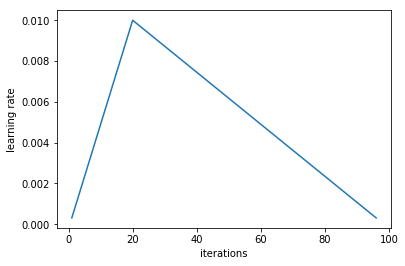

In [144]:
learn.sched.plot_lr()

In [145]:
learn.save('reg1_0')

In [146]:
learn.freeze_to(-2)

In [153]:
len(learn.get_layer_groups())

3

In [155]:
learn.get_layer_groups()[2]

Sequential(
  (0): Sequential(
    (0): Flatten(
    )
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=25088, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): Dropout(p=0.5)
    (7): Linear(in_features=256, out_features=24, bias=True)
  )
)

In [177]:
learn[-3]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [181]:
learn[-2:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_

In [147]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:08<00:01,  3.13it/s, loss=136] 


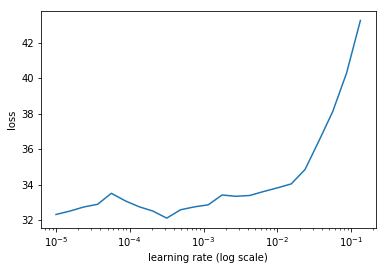

In [148]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [149]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      35.131685  37.773964  0.792969   25.656124 
    1      29.374064  32.619186  0.820613   21.356963     
    2      24.597134  31.980824  0.819712   20.970021     
    3      21.115857  31.868015  0.81235    20.83674      
    4      18.672846  31.483252  0.824519   20.381135     



[31.483252, 0.8245192319154739, 20.381134748458862]

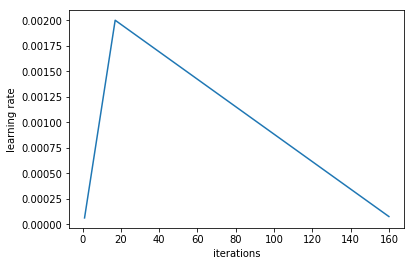

In [150]:
learn.sched.plot_lr()

In [184]:
learn.save('reg1_1')

In [185]:
learn.load('reg1_1')

In [186]:
learn.unfreeze()

In [187]:
learn.fit(lrs/5, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.927503  34.11573   0.8128     21.191871 
    1      17.924181  33.7691    0.795373   20.661585     
    2      17.564491  36.224354  0.789964   20.049127     
    3      16.637256  34.60907   0.804537   19.54396      
    4      15.565688  33.261505  0.79973    18.796685     
    5      14.321039  32.278984  0.820763   18.895897     
    6      13.427127  31.12686   0.825571   18.177243     
    7      12.672469  31.412361  0.816857   18.203102     
    8      11.727752  31.182291  0.822716   18.204582     
    9      11.120245  31.016346  0.822716   18.179165     



[31.016346, 0.8227163478732109, 18.179165363311768]

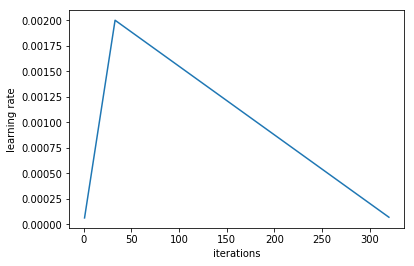

In [190]:
learn.sched.plot_lr()

In [188]:
learn.save('reg1')

In [189]:
learn.load('reg1')

In [191]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [193]:
y.shape

(500, 24)

In [196]:
x.shape

torch.Size([64, 3, 224, 224])

In [194]:
from scipy.special import expit
# sigmoid function 1 / (1+e^-x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


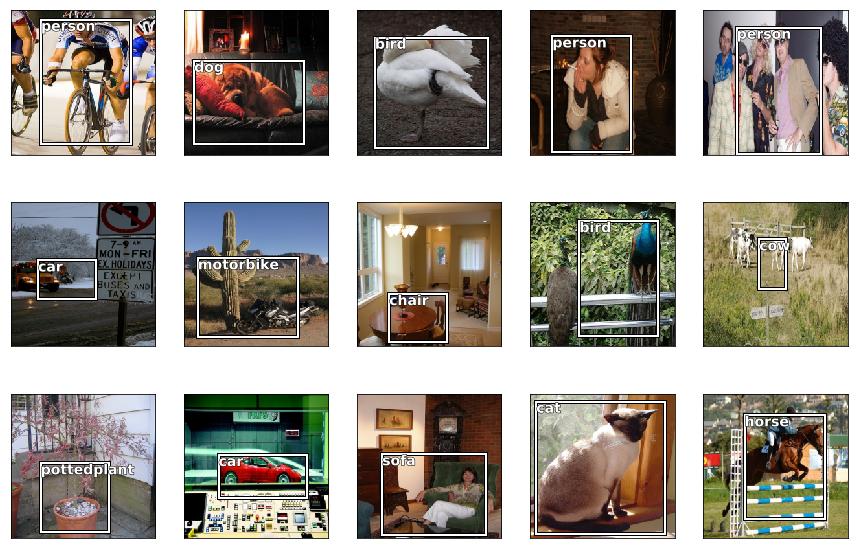

In [201]:
fig, axes = plt.subplots(3,5, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])

## End